In [1]:
%matplotlib inline

from io import BytesIO
from difflib import SequenceMatcher
import requests

import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import seaborn as sns
import scipy.stats as ss

In [2]:
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams["figure.facecolor"] = "white"

In [3]:
with open("../discogs_api.txt", "r") as f:
    text = f.read().splitlines()

_, c_key = text[0].split(": ")
_, c_secret = text[1].split(": ")

In [4]:
rym_top_500 = pd.read_csv("../data/rym_top_500_albums.tsv", sep="\t", index_col=0)
rym_top_500.head()

,album_id,artist,name,date,genres,rating,num_ratings,num_reviews
position,,,,,,,,
1,Album45,Radiohead,Ok Computer,1997,"Alternative Rock, Art Rock",4.23,60527,1583
2,Album46,Radiohead,Kid A,2000,"Art Rock, Experimental Rock, Electronic",4.23,50279,714
3,Album976,Pink Floyd,The Dark Side Of The Moon,1973,"Art Rock, Progressive Rock",4.23,50633,1524
4,Album974,Pink Floyd,Wish You Were Here,1975,"Progressive Rock, Art Rock",4.29,41760,939
5,Album2328,King Crimson,In The Court Of The Crimson King,1969,"Progressive Rock, Art Rock",4.31,37873,828


In [5]:
rs_top_500 = pd.read_csv("../data/rs_top_500_albums.tsv", sep="\t", index_col=0)
rs_top_500 = rs_top_500.replace(19755, 1975) # site has one entry as 19755
print(rs_top_500.shape)
rs_top_500.head()

(500, 3)


,artist,name,date
position,,,
1,Marvin Gaye,What'S Going On,1971
2,The Beach Boys,Pet Sounds,1966
3,Joni Mitchell,Blue,1971
4,Stevie Wonder,Songs In The Key Of Life,1976
5,The Beatles,Abbey Road,1969


In [6]:
rs_top_500[rs_top_500["artist"] == "Brian Eno"]

,artist,name,date
position,,,
308,Brian Eno,Here Come The Warm Jets,1974
338,Brian Eno,Another Green World,1975


In [7]:
rym_album_set = set([tuple(row[["artist", "name"]]) for i, row in rym_top_500.iterrows()])
rs_album_set = set([tuple(row[["artist", "name"]]) for i, row in rs_top_500.iterrows()])

In [8]:
both_album_set = rym_album_set.intersection(rs_album_set)
print(len(both_album_set))

157


In [9]:
rym_only = rym_album_set.difference(rs_album_set)
rs_only = rs_album_set.difference(rym_album_set)
print(len(rym_only))
print(len(rs_only))

343
343


Look for albums that are very close to each other.

In [10]:
# create similarity matrix
# rows: rolling stones
# columns: rym
sim_mat = np.zeros([len(rs_only), len(rym_only), 2])
for i, rs_album in enumerate(rs_only):
    for j, rym_album in enumerate(rym_only):
        # sort by decreasing length
        #lambda x: len(x)
        #rs_album = sorted(rs_album, key=lambda x: len(x), reverse=True)
        #rym_album = sorted(rs_album, key=lambda x: len(x), reverse=True)
        
        artist_ratio = SequenceMatcher(None, rs_album[0], rym_album[0]).ratio()
        if artist_ratio >= 0.4 and (rs_album[0] in rym_album[0] or rym_album[0] in rs_album[0]):
            artist_ratio = 1.0
        
        album_ratio = SequenceMatcher(None, rs_album[1], rym_album[1]).ratio()
        if album_ratio >= 0.4 and (rs_album[1] in rym_album[1] or rym_album[1] in rs_album[1]):
            album_ratio = 1.0          
        
        sim_mat[i][j][0] = artist_ratio
        sim_mat[i][j][1] = album_ratio

In [11]:
sim_mat[:, :, 0].shape

(343, 343)

In [12]:
artist_sim_df = pd.DataFrame(sim_mat[:, :, 0])
artist_sim_df.index = rs_only
artist_sim_df.columns = rym_only

album_sim_df = pd.DataFrame(sim_mat[:, :, 1])
album_sim_df.index = rs_only
album_sim_df.columns = rym_only

In [13]:
artist_album_sims = sim_mat.reshape([343*343, 2])
artist_album_sims[:,0]

array([0.19354839, 0.19047619, 0.16666667, ..., 0.28571429, 0.54545455,
       0.23529412])

Look for entries w/ artist similarity > 0.6 & artist similarity > 0.6

In [14]:
album_id_combos = list(zip(*np.where((sim_mat[:, :, 0] >= 0.5) & (sim_mat[:, :, 1] >= 0.7))))
album_combos = [(list(rs_only)[i], list(rym_only)[j], sim_mat[i, j, 0], sim_mat[i, j, 1]) for i, j in album_id_combos]
for x in sorted(album_combos, key=lambda x: np.mean(x[2:4])): print(x)
print(len(album_combos))

(('BjöRk', 'Post'), ('Björk', 'Post'), 0.5454545454545454, 1.0)
(('Weezer', 'Weezer (The Blue Album)'), ('Weezer', 'Weezer [Blue Album]'), 1.0, 0.8095238095238095)
(('Prince', "Sign O' The Times"), ('Prince', 'Sign "☮" The Times'), 1.0, 0.8571428571428571)
(('Elliott Smith', 'Either\\/Or'), ('Elliott Smith', 'Either / Or'), 1.0, 0.8571428571428571)
(('The Rolling Stones', 'Exile On Main Street'), ('The Rolling Stones', 'Exile On Main St.'), 1.0, 0.8648648648648649)
(('Led Zeppelin', 'Led Zeppelin Iv'), ('Led Zeppelin', 'Led Zeppelin Iii'), 1.0, 0.9032258064516129)
(('Can', 'Ege Bamyasi'), ('Can', 'Ege Bamyası'), 1.0, 0.9090909090909091)
(('Sly And The Family Stone', "There'S A Riot Goin' On"), ('Sly & The Family Stone', "There'S A Riot Goin' On"), 0.9130434782608695, 1.0)
(('Crosby, Stills, Nash, And Young', 'Déjà Vu'), ('Crosby, Stills, Nash & Young', 'Déjà Vu'), 0.9152542372881356, 1.0)
(('New Order', 'Power, Corruption &Amp; Lies'), ('New Order', 'Power, Corruption & Lies'), 1.0, 0

In [15]:
album_combos.remove((('Led Zeppelin', 'Led Zeppelin Iv'), ('Led Zeppelin', 'Led Zeppelin Iii'), 1.0, 0.9032258064516129))

In [16]:
final_both_album_set = both_album_set.union(set([x[1] for x in album_combos]))
final_rym_only_set = rym_only.copy()
final_rs_only_set = rs_only.copy()

for combo in album_combos:
    final_rym_only_set.remove(combo[1])
    final_rs_only_set.remove(combo[0])

print(len(final_both_album_set))
print(len(final_rs_only_set))
print(len(final_rym_only_set))

192
308
308


In [17]:
final_both_album_set

{('A Tribe Called Quest', 'Midnight Marauders'),
 ('A Tribe Called Quest', 'The Low End Theory'),
 ('Alice Coltrane Featuring Pharoah Sanders', 'Journey In Satchidananda'),
 ('Arcade Fire', 'Funeral'),
 ('Beastie Boys', "Paul'S Boutique"),
 ('Belle And Sebastian', "If You'Re Feeling Sinister"),
 ('Björk', 'Homogenic'),
 ('Björk', 'Post'),
 ('Black Sabbath', 'Black Sabbath'),
 ('Black Sabbath', 'Master Of Reality'),
 ('Black Sabbath', 'Paranoid'),
 ('Bob Dylan', 'Blonde On Blonde'),
 ('Bob Dylan', 'Blood On The Tracks'),
 ('Bob Dylan', 'Bringing It All Back Home'),
 ('Bob Dylan', 'Highway 61 Revisited'),
 ('Bob Dylan', "The Freewheelin' Bob Dylan"),
 ('Bob Marley', 'Exodus'),
 ('Bon Iver', 'For Emma, Forever Ago'),
 ('Bruce Springsteen', 'Born To Run'),
 ('Bruce Springsteen', 'Darkness On The Edge Of Town'),
 ('Bruce Springsteen', 'Nebraska'),
 ('Can', 'Ege Bamyası'),
 ('Charles Mingus', 'Mingus Ah Um'),
 ('Cocteau Twins', 'Heaven Or Las Vegas'),
 ('Creedence Clearwater Revival', "Cosmo

In [18]:
_df1 = rym_top_500.copy()
_df1["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in _df1.iterrows()]
_df1 = _df1[_df1["artist_name"].isin(["_".join(x) for x in final_rym_only_set])]
rym_only_df = _df1.copy()
_df1 = _df1["date"].value_counts().to_frame().reset_index()
_df1 = _df1.rename(columns={"index": "date", "date": "count"})
_df1 = _df1.set_index("date")

_df2 = rs_top_500.copy()
_df2["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in _df2.iterrows()]
_df2 = _df2[_df2["artist_name"].isin(["_".join(x) for x in final_rs_only_set])]
rs_only_df = _df2.copy()
_df2 = _df2["date"].value_counts().to_frame().reset_index()
_df2 = _df2.rename(columns={"index": "date", "date": "count"})
_df2 = _df2.set_index("date")

_df3 = rym_top_500.copy()
_df3["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in _df3.iterrows()]
_df3 = _df3[_df3["artist_name"].isin(["_".join(x) for x in final_both_album_set])]
_df3 = _df3.groupby(["date"]).size().to_frame()
_df3 = _df3.rename(columns={0: "count"})
#_df3 = _df3.reset_index()

year_df = _df1.join(_df2, lsuffix="_RYM", rsuffix="_RS", how="outer").join(_df3, how="outer").fillna(0)
year_df = year_df.rename(columns={"count": "count_BOTH"})
year_df["sum"] = year_df.sum(axis=1)
year_df = year_df.sort_index()
year_df

,count_RYM,count_RS,count_BOTH,sum
date,,,,
1955,0.0,1.0,0.0,1.0
1956,0.0,1.0,0.0,1.0
1957,1.0,1.0,0.0,2.0
1958,3.0,2.0,0.0,5.0
1959,2.0,1.0,3.0,6.0
...,...,...,...,...
2016,8.0,4.0,1.0,13.0
2017,4.0,2.0,1.0,7.0
2018,7.0,3.0,0.0,10.0


In [19]:
album_match_dict = {"_".join(x[0]): "_".join(x[1]) for x in album_combos}
print(len(album_match_dict.keys()))
album_match_dict

35


{'BjöRk_Post': 'Björk_Post',
 'John Lennon_Plastic Ono Band': 'John Lennon_John Lennon / Plastic Ono Band',
 'Alice Coltrane_Journey In Satchidanada': 'Alice Coltrane Featuring Pharoah Sanders_Journey In Satchidananda',
 'Bon Iver_For Emma': 'Bon Iver_For Emma, Forever Ago',
 'Joy Divison_Closer': 'Joy Division_Closer',
 'The Velvet Underground_White Light\\/White Heat': 'The Velvet Underground_White Light / White Heat',
 'Brian Eno_Another Green World': 'Eno_Another Green World',
 'The Rolling Stones_Exile On Main Street': 'The Rolling Stones_Exile On Main St.',
 "Prince_Sign O' The Times": 'Prince_Sign "☮" The Times',
 'Can_Ege Bamyasi': 'Can_Ege Bamyası',
 'Magnetic Fields_69 Love Songs': 'The Magnetic Fields_69 Love Songs',
 'Wu-Tang Clan_Enter The Wu-Tang(36 Chambers)': 'Wu-Tang Clan_Enter The Wu-Tang (36 Chambers)',
 'The Smashing Pumpkins_Siamese Dream': 'Smashing Pumpkins_Siamese Dream',
 'Brian Eno_Here Come The Warm Jets': 'Eno_Here Come The Warm Jets',
 "Sly And The Family 

In [20]:
rank_df = rym_top_500.copy()
rank_df["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in rank_df.iterrows()]
rank_df = rank_df[rank_df["artist_name"].isin(["_".join(x) for x in final_both_album_set])]
rank_df = rank_df.reset_index()
rank_df = rank_df.set_index("artist_name", drop=False)
rank_df = rank_df[["position", "rating", "num_ratings", "num_reviews"]]

_df2 = rs_top_500.copy()
_df2["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in _df2.iterrows()]
_df2 = _df2.replace(album_match_dict)
_df2 = _df2[_df2["artist_name"].isin(["_".join(x) for x in final_both_album_set])]
_df2 = _df2.reset_index()

rank_df = rank_df.join(_df2.set_index("artist_name"), how="inner", lsuffix="_RYM", rsuffix="_RS")
rank_df["avg_pos"] = (rank_df["position_RYM"] + rank_df["position_RS"])/2
rank_df.head()

,position_RYM,rating,num_ratings,num_reviews,position_RS,artist,name,date,avg_pos
artist_name,,,,,,,,,
Radiohead_Ok Computer,1,4.23,60527,1583,42,Radiohead,Ok Computer,1997,21.5
Radiohead_Kid A,2,4.23,50279,714,20,Radiohead,Kid A,2000,11.0
Pink Floyd_The Dark Side Of The Moon,3,4.23,50633,1524,55,Pink Floyd,The Dark Side Of The Moon,1973,29.0
Pink Floyd_Wish You Were Here,4,4.29,41760,939,264,Pink Floyd,Wish You Were Here,1975,134.0
The Velvet Underground_The Velvet Underground & Nico,6,4.25,40013,918,23,The Velvet Underground,The Velvet Underground And Nico,1967,14.5


In [21]:
rank_df.sort_values(by=["avg_pos"], ascending=True).head()

,position_RYM,rating,num_ratings,num_reviews,position_RS,artist,name,date,avg_pos
artist_name,,,,,,,,,
The Beach Boys_Pet Sounds,10,4.19,31745,886,2,The Beach Boys,Pet Sounds,1966,6.0
The Beatles_Abbey Road,15,4.26,38533,1126,5,The Beatles,Abbey Road,1969,10.0
Radiohead_Kid A,2,4.23,50279,714,20,Radiohead,Kid A,2000,11.0
Kendrick Lamar_To Pimp A Butterfly,8,4.24,34762,324,19,Kendrick Lamar,To Pimp A Butterfly,2015,13.5
The Velvet Underground_The Velvet Underground & Nico,6,4.25,40013,918,23,The Velvet Underground,The Velvet Underground And Nico,1967,14.5


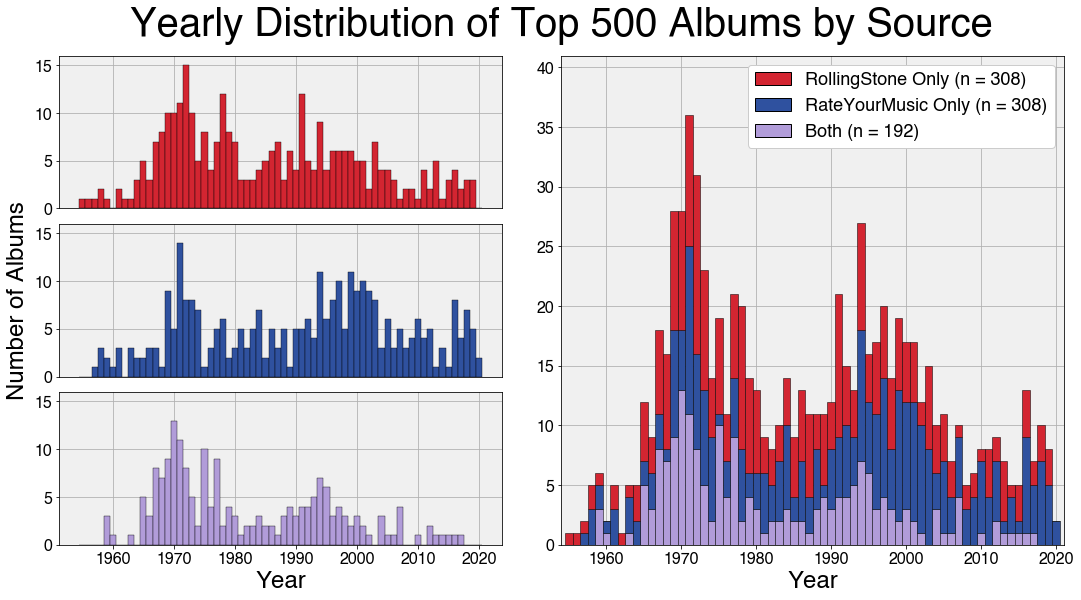

In [22]:
fig = plt.figure(figsize=(18, 9))
heights = [1, 1, 1]
widths = [2, 1, 1]
spec = fig.add_gridspec(nrows=3, ncols=3, height_ratios=heights, width_ratios=widths)

ax1 = fig.add_subplot(spec[:, 1:3])
ax4 = fig.add_subplot(spec[2, 0])
ax2 = fig.add_subplot(spec[0, 0])#, sharex=ax4)
ax3 = fig.add_subplot(spec[1, 0])#, sharex=ax3)

plt.subplots_adjust(hspace=0.1)

color_dict = {
    "count_RYM": "#2F519F",
    "count_RS": "#d32531",
    "count_BOTH": "#b19cd9"
}

min_year = min(rym_top_500["date"].min(), rs_top_500["date"].min())
max_year = max(rym_top_500["date"].max(), rs_top_500["date"].max())
year_range = np.arange(round(min_year/10)*10, round(max_year/10)*10+10, 10)
order = ["count_BOTH", "count_RYM", "count_RS"]
axs = [ax4, ax3, ax2]

for i, col in enumerate(order):
    _df = year_df[order]
    ax1.bar(
        _df.index,
        _df[col],
        bottom=np.sum(_df.values[:, :i], axis=1),
        color=color_dict.get(col),
        label=col,
        width=1,
        edgecolor="black",
        lw=0.5,
        zorder=2,
    )

    
    _ax = axs[i]
    _ax.bar(
        _df.index,
        _df[col],
        color=color_dict.get(col),
        label=col,
        width=1,
        edgecolor="black",
        lw=0.4,
        zorder=2,
    )
    _ax.set_ylim([0, 16])
    _ax.set_yticks([0, 5, 10, 15])
    _ax.set_xticks(year_range)
    _ax.set_xticklabels(year_range, fontsize=16)

ax1.set_xlim([min_year-1, max_year+1])
ax1.set_ylim([0, 41])

handles = [
    mpatches.Patch(facecolor=color_dict.get(x), edgecolor="black", label=x) for x in order
]


ax1.legend(
    handles=handles[::-1],
    labels=[
        f"Both (n = {len(final_both_album_set)})",
        f"RateYourMusic Only (n = {len(final_rym_only_set)})",
        f"RollingStone Only (n = {len(final_rs_only_set)})",    
    ][::-1],
    fontsize=18,
    framealpha=1,
    #frameon=False,
)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_facecolor("#F0F0F0")
    ax.grid(zorder=0, which="major", axis="both")
    ax.tick_params("both", labelsize=16)
    
ax2.set_xticklabels([])
ax2.tick_params("x", length=0)
ax3.set_xticklabels([])
ax3.tick_params("x", length=0)

# https://stackoverflow.com/questions/6963035/pyplot-axes-labels-for-subplots/6981055#6981055

axbig = fig.add_subplot(111, zorder=0, facecolor="None")
axbig.spines['top'].set_color('none')
axbig.spines['bottom'].set_color('none')
axbig.spines['left'].set_color('none')
axbig.spines['right'].set_color('none')
axbig.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
axbig.xaxis.set_visible(False)
axbig.set_xticks([])
axbig.set_yticks([])
axbig.set_title("Yearly Distribution of Top 500 Albums by Source", fontsize=40, pad=20)
#axbig.set_xlabel("Year", fontsize=24)
axbig.set_ylabel("Number of Albums", fontsize=24, labelpad=30)

ax1.set_xlabel("Year", fontsize=24)
ax4.set_xlabel("Year", fontsize=24)

plt.savefig("figures/yearly_distribution_by_source.png", dpi=500, bbox_inches="tight")

plt.show()

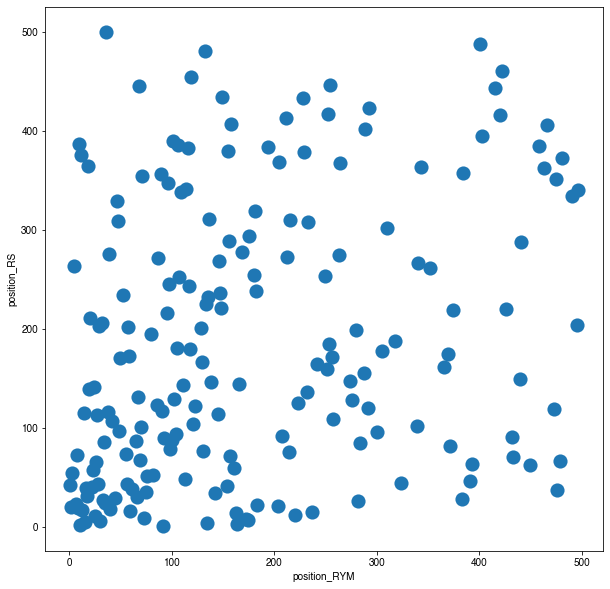

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.scatterplot(
    data=rank_df,
    x="position_RYM",
    y="position_RS",
    #hue="rating",
    #palette="viridis",
    linewidth=0,
    s=200,
    ax=ax,
    legend=None,
)

x1 = rank_df["position_RS"]
x2 = rank_df["position_RYM"]

spearman = ss.spearmanr(x1, x2)

plt.show()

In [24]:
spearman

SpearmanrResult(correlation=0.3042583349157692, pvalue=1.7822135706656636e-05)

In [25]:
shared_artists = rank_df["artist"].value_counts()[rank_df["artist"].value_counts() >= 4]
shared_artists

Led Zeppelin          5
Kanye West            5
Bob Dylan             5
Neil Young            5
The Beatles           5
David Bowie           5
The Rolling Stones    4
Pink Floyd            4
Radiohead             4
Name: artist, dtype: int64

In [26]:
# download album covers
"""
import time

url = "https://api.discogs.com/database/search?q="
for artist in shared_artists.index.tolist():
    albums = rank_df[rank_df["artist"] == artist].index.tolist()
    for album in albums:
        album = album.replace("_", " ")
        print(album)
        query = f"{url}{album}&type=release&format_exact=Album&key={c_key}&secret={c_secret}"
        image_url = requests.get(query).json()["results"][0]["cover_image"]
        time.sleep(5)
        img = Image.open(BytesIO(requests.get(image_url).content))
        img = img.resize((100, 100))
        img.save(f"../imgs/album_covers/{album}.png")
"""
print()

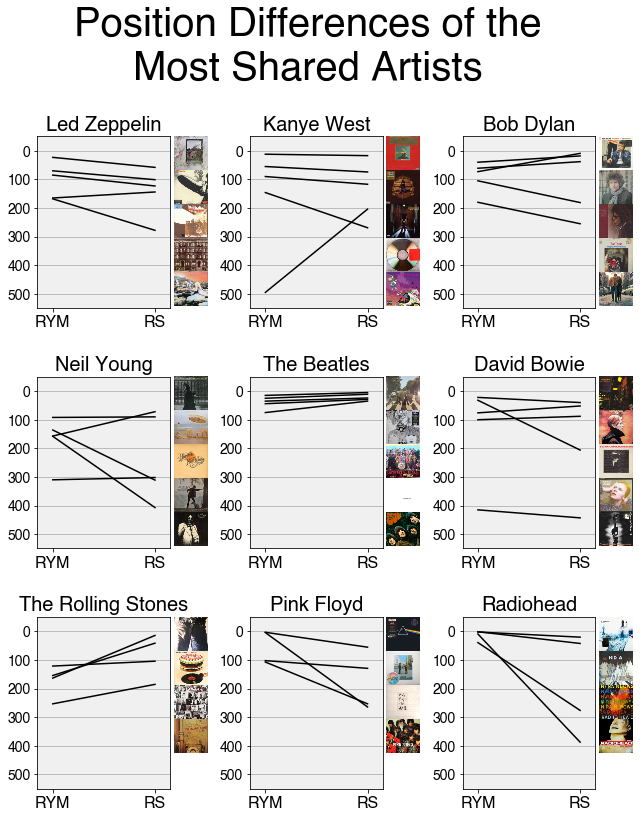

In [27]:
fig, axs = plt.subplots(3, 3, figsize=(10, 12), facecolor="white")
plt.subplots_adjust(wspace=0.6, hspace=0.4)

for ax, artist in zip(axs.flatten(), shared_artists.index):
    # double reset to avoid weird indexing issue from before
    _df = rank_df[rank_df["artist"] == artist].reset_index().reset_index()
    _df = _df.sort_values(by="position_RS")
    for i, row in _df.iterrows():
        sns.lineplot(
            x=[0, 1],
            y=[row["position_RYM"], row["position_RS"]],
            ax=ax,
            color="black"
        )
        
        artist_album = row["artist_name"].replace("_", " ")
        img_file = f"../imgs/album_covers/{artist_album}.png"
        img = mpimg.imread(f"../imgs/album_covers/{artist_album}.png")
        imagebox = OffsetImage(img, zoom=0.34)
        ab = AnnotationBbox(imagebox, (1.15, 0), frameon = False, box_alignment=(-0.1, 0.57+i))
        ax.add_artist(ab)
        
    ax.set_title(artist, fontsize=20)
    ax.set_ylim([550, -50])
    ax.set_xlim([-0.15, 1.15])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["RYM", "RS"], fontsize=16)
    ax.tick_params("y", labelsize=14)
    ax.set_facecolor("#F0F0F0")
    ax.grid(zorder=0, which="major", axis="y")

plt.suptitle("Position Differences of the\nMost Shared Artists", fontsize=40, y=1.03)
plt.savefig("figures/position_diff_shared_artists.png", dpi=500, bbox_inches="tight")

plt.show()

In [28]:
rym_only_df["artist"].value_counts()

Iron Maiden             5
King Crimson            4
John Coltrane           4
Miles Davis             4
Death                   4
                       ..
Broken Social Scene     1
Sonny Rollins           1
Vangelis                1
Jpegmafia               1
Iggy And The Stooges    1
Name: artist, Length: 210, dtype: int64

In [29]:
rs_only_df["artist"].value_counts()

The Beatles            4
Aretha Franklin        4
Madonna                3
Big Star               3
Joni Mitchell          3
                      ..
Jefferson Airplane     1
Pet Shop Boys          1
My Chemical Romance    1
George Michael         1
Amy Winehouse          1
Name: artist, Length: 246, dtype: int64

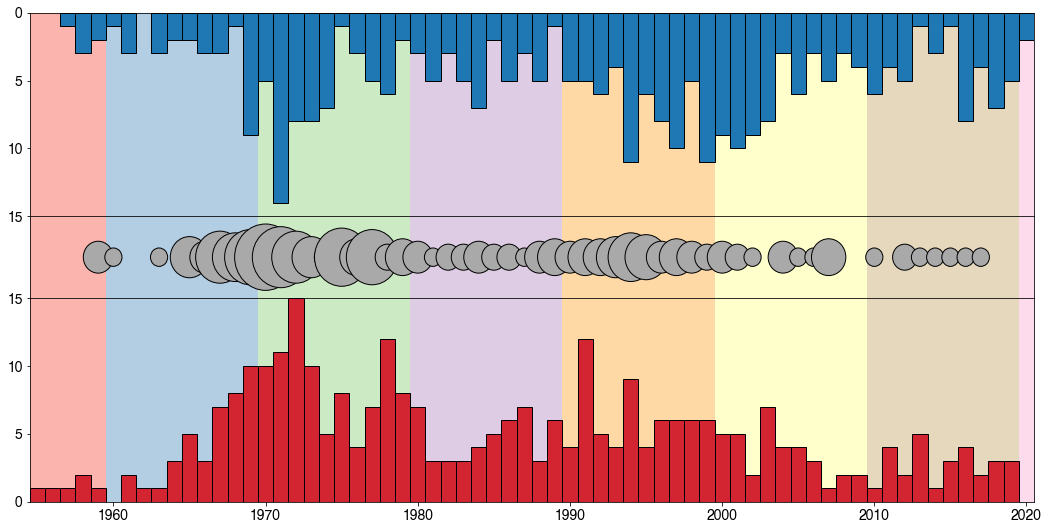

In [30]:
fig = plt.figure(figsize=(18, 9))
heights = [5, 2, 5]
spec = fig.add_gridspec(nrows=3, ncols=1, height_ratios=heights)

ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])
ax3 = fig.add_subplot(spec[2])

plt.subplots_adjust(hspace=0.0)

min_year = min(rym_top_500["date"].min(), rs_top_500["date"].min())
max_year = max(rym_top_500["date"].max(), rs_top_500["date"].max())

# rym only
_df1 = rym_top_500.copy()
_df1["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in _df1.iterrows()]
_df1 = _df1[_df1["artist_name"].isin(["_".join(x) for x in final_rym_only_set])]
_df1 = _df1["date"].value_counts().to_frame().reset_index()

#ax1.hist(_df1["date"], bins=max_year-min_year, bottom=0)
ax1.bar(_df1["index"], _df1["date"], width=1, edgecolor="black")
ax1.set_ylim([0, 15])
ax1.set_yticks(np.arange(0, 16, 5))
ax1.invert_yaxis()
ax1.xaxis.set_visible(False)

bg_palette = sns.color_palette("Pastel1", 8)

for ax in [ax1, ax2, ax3]:
    ax.set_xlim([min_year-0.5, max_year+0.5])
    #ax.set_xticks(np.arange(min_year, max_year+1))
    for i, yr in enumerate(np.arange(round(min_year/10)*10-10, round(max_year/10)*10+10, 10)):
        #ax.axvline(x=yr, zorder=0, linestyle="--", color="black")
        ax.axvspan(yr-0.5, yr+10.5, facecolor=bg_palette[i], zorder=0)
        pass

# rolling stones only
_df2 = rs_top_500.copy()
_df2["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in _df2.iterrows()]
_df2 = _df2[_df2["artist_name"].isin(["_".join(x) for x in final_rs_only_set])]
_df2 = _df2["date"].value_counts().to_frame().reset_index()

ax3.bar(_df2["index"], _df2["date"], width=1, color="#d32531", edgecolor="black")
ax3.set_ylim([0, 15])
ax3.set_yticks(np.arange(0, 16, 5))
ax3.tick_params("both", labelsize=14)

# middle
_df3 = rym_top_500.copy()
_df3["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in _df3.iterrows()]
_df3 = _df3[_df3["artist_name"].isin(["_".join(x) for x in final_both_album_set])]
_df3 = _df3.groupby(["date"]).size().to_frame()
_df3 = _df3.rename(columns={0: "count"})
_df3 = _df3.reset_index()

#ax2.bar(_df3["date"], _df3["count"], width=1, color="gray", edgecolor="black")

ax2.set_ylim([0, 5])
#ax2.set_xlim([0, 65])
#ax2.axis("equal")

_df3["radius"] = _df3["count"].apply(lambda x: np.sqrt(x/np.pi))

for i, row in _df3.iterrows():
    p = mpatches.Circle(
        (row["date"], ax2.get_ylim()[1]/2),
        radius=row["radius"],
        facecolor="darkgray",
        edgecolor="black",
    )
    ax2.add_patch(p)

ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
    
for ax in [ax1, ax3]:
    ax.tick_params("y", labelsize=14)
    #ax.set_ylabel("# Albums", fontsize=18)

plt.show()